In [13]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import numpy as np
import pandas as pd

from flareTools import FINDflare, IRLSSpline

mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

In [4]:
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec7/'

# Flare star candidates that Jim picked out
f1 = 'tess2019006130736-s0007-0000000458616184-0131-s_lc.fits'
f2 = 'tess2019006130736-s0007-0000000458648813-0131-s_lc.fits'
f3 = 'tess2019006130736-s0007-0000000453002670-0131-s_lc.fits'

Text(0, 0.5, 'Flux [e-/s]')

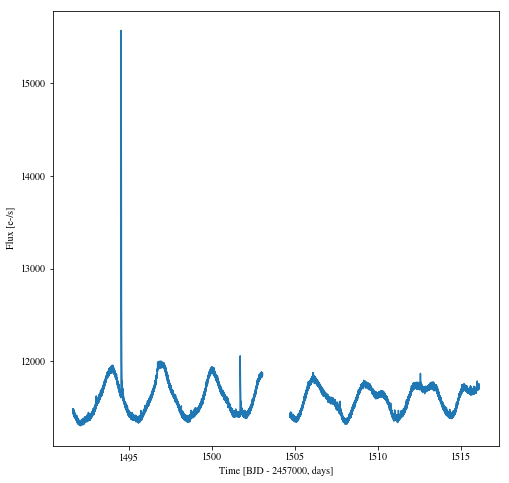

In [6]:
# Take a look at light curve #1
with fits.open(path+f1, mode='readonly') as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(tess_bjds, pdcsap_fluxes)
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

In [18]:
# Throw out NaN fluxes
mask = ~np.isnan(pdcsap_fluxes)
time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
median_flux = np.median(flux)
error = pdcsap_flux_error[mask]

In [19]:
# Identify flares using change point analysis function
istart_i, istop_i = FINDflare(flux, error)

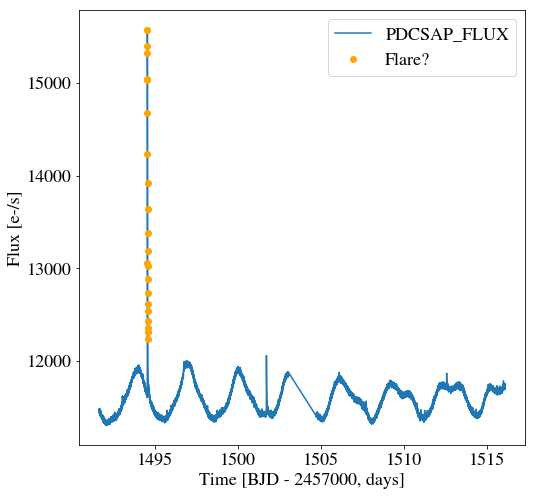

In [20]:
fig, axes = plt.subplots(figsize=(8,8))
axes.plot(time, flux, label='PDCSAP_FLUX')
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

for idx in range(len((istart_i))):
    l = 'Flare?' if idx == 0 else '_nolabel_'
    axes.plot(time[istart_i[idx]:istop_i[idx]], flux[istart_i[idx]:istop_i[idx]], 'o', color='orange', label=l)
    
axes.legend()

In [21]:
# Find flares in the light curve with the rolling median subtracted
smo = pd.DataFrame(flux).rolling(128, center=True).median().values
smo = smo.reshape(1, -1)[0]

istart_i, istop_i = FINDflare((flux-smo)/median, error/median, avg_std=True, N1=3, N2=4, N3=3)

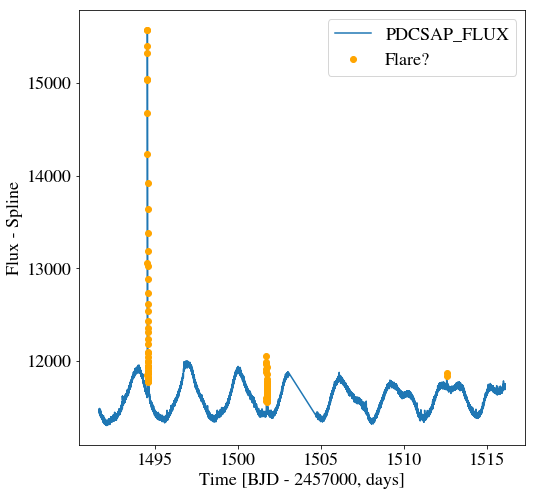

In [22]:
fig, axes = plt.subplots(figsize=(8,8))
axes.plot(time, flux, label='PDCSAP_FLUX')
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux - Spline')

for idx in range(len((istart_i))):
    l = 'Flare?' if idx == 0 else '_nolabel_'
    axes.plot(time[istart_i[idx]:istop_i[idx]], flux[istart_i[idx]:istop_i[idx]], 'o', color='orange', label=l)
    
axes.legend()

In [25]:
# Now try an iterative re-weight least squares spline fit to
# detrend the light curve first
spline = IRLSSpline(time, flux, error)

istart_i, istop_i = FINDflare((flux-spline)/median, error/median, avg_std=True, N1=3, N2=4, N3=3)

Text(0, 0.5, 'Flux - Spline')

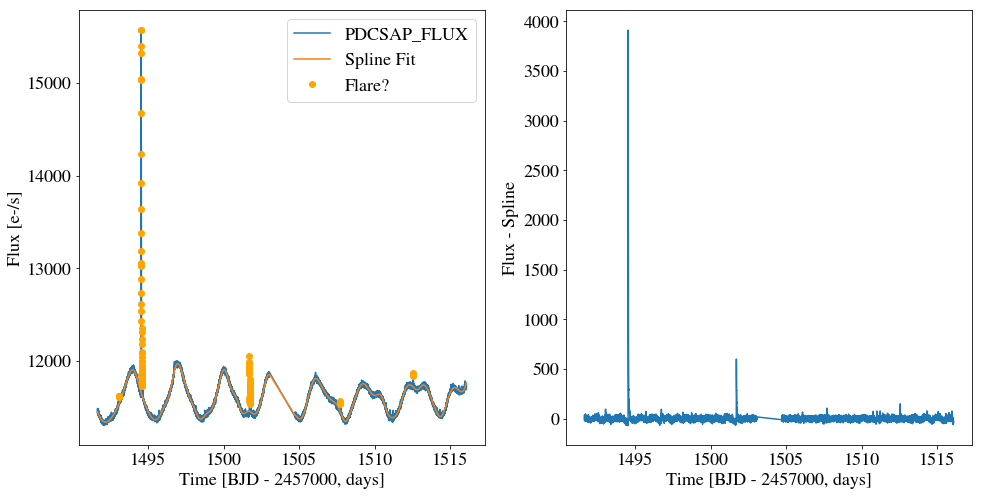

In [27]:
fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
axes[0].plot(time, flux, label='PDCSAP_FLUX')
axes[0].plot(time, spline, label='Spline Fit')
axes[0].set_xlabel('Time [BJD - 2457000, days]')
axes[0].set_ylabel('Flux [e-/s]')

for idx in range(len((istart_i))):
    l = 'Flare?' if idx == 0 else '_nolabel_'
    axes[0].plot(time[istart_i[idx]:istop_i[idx]], flux[istart_i[idx]:istop_i[idx]], 'o', color='orange', label=l)

axes[0].legend()

axes[1].plot(time, flux-spline)
axes[1].set_xlabel('Time [BJD - 2457000, days]')
axes[1].set_ylabel('Flux - Spline')